# Spaceship Titanic

Our goal is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly.


## File and Data Field Descriptions

* **train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
    * PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
    * HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
    * CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    * Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    * Destination - The planet the passenger will be debarking to.
    * Age - The age of the passenger.
    * VIP - Whether the passenger has paid for special VIP service during the voyage.
    * RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    * Name - The first and last names of the passenger.
    * Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
* **test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
* **sample_submission.csv** - A submission file in the correct format.
    * PassengerId - Id for each passenger in the test set.
    * Transported - The target. For each passenger, predict either True or False.

## Libraries imports

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

## 1) Dataset loading and preprocess

First of all, we load the training and test sets.

In [2]:
# Load a dataset into a Pandas Dataframe
# Try to load the dataset from Kaggle, if not found, load from local directory
try:
    train_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
    test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
except FileNotFoundError:
    train_df = pd.read_csv('kaggle/input/spaceship-titanic/train.csv')
    test_df = pd.read_csv('kaggle/input/spaceship-titanic/test.csv')

print("Full train dataset shape is {}".format(train_df.shape))
print("Full test dataset shape is {}".format(test_df.shape))

Full train dataset shape is (8693, 14)
Full test dataset shape is (4277, 13)


In [3]:
# I split the datasets into features (X) and tag (Y)
train_x = train_df.drop(columns=['Transported'])
train_y = train_df['Transported'].astype(int)  # Convert boolean to int (0 or 1)

test_x = test_df

To evaluate the different models used, I will one 5-fold Cross-Validation, so there is no need to created a validation dataset from the training data, so the next step is to preprocess the dataset, to do that I will check each individual feature.

### PassengerId

This variable represents a unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

At the begining it seems to be a variant without information to solve the problem, something like a name, however as it said, we can extract the number of members that each group has and that can be something relevant.
However to know the number of members a group has, we have to use the whole dataset, trining + test sets. To do this would be a problem in most cases because we are not sure that our dataset contain all the existent samples, however for this task, the description tells us that we have about two-thirds (~8700) of the passengers as the training set and THE REMAINING one-third (~4300) of the passengers as test, so we got at least partial information about all the passengers.

In [4]:
# Check for missing values in PassengerId
print("Missing values in PassengerId:")
print(f"train_x: {train_x['PassengerId'].isnull().sum()}")
print(f"test_x: {test_x['PassengerId'].isnull().sum()}")

# Extract group identifier (gggg) from PassengerId
train_x['Group'] = train_x['PassengerId'].str.split('_').str[0]
test_x['Group'] = test_x['PassengerId'].str.split('_').str[0]

# Combine all dataframes to calculate group sizes across all datasets
combined_df = pd.concat([train_x, test_x])

# Calculate the total number of members in each group
group_sizes = combined_df['Group'].value_counts()

# Add the numMembers column to each dataframe
train_x['numMembers'] = train_x['Group'].map(group_sizes)
test_x['numMembers'] = test_x['Group'].map(group_sizes)

# Display the updated dataframes
print("Updated train_x:")
print(train_x[['PassengerId', 'Group', 'numMembers']].head())

print("\nUpdated test_x:")
print(test_x[['PassengerId', 'Group', 'numMembers']].head())


Missing values in PassengerId:
train_x: 0
test_x: 0
Updated train_x:
  PassengerId Group  numMembers
0     0001_01  0001           1
1     0002_01  0002           1
2     0003_01  0003           2
3     0003_02  0003           2
4     0004_01  0004           1

Updated test_x:
  PassengerId Group  numMembers
0     0013_01  0013           1
1     0018_01  0018           1
2     0019_01  0019           1
3     0021_01  0021           1
4     0023_01  0023           1


Now we can remove the columns PassengerId and Group, that don't give us any more information, however I will wait and remove all the useless columns after analyze all the features.

### HomePlanet 
The planet the passenger departed from, typically their planet of permanent residence.

This is a categorical feature, so we will need to encode it in some way in order to give the information to the models.

In [5]:
# First I check how many different values we have in this variant (HomePlanet)
print("HomePlanet unique values: ", train_x['HomePlanet'].unique())

# And also if there are any missing values and how many
print("Missing values in HomePlanet: ", train_x['HomePlanet'].isnull().sum(), f"({train_x['HomePlanet'].isnull().sum()/len(train_x)*100:.2f}%)")

HomePlanet unique values:  ['Europa' 'Earth' 'Mars' nan]
Missing values in HomePlanet:  201 (2.31%)


First of all, let's solve the issue with the missing values, we can assume that members of the same group depart from the same planet, so the first approach will be to assign the existing value of one member of the group to other members that have a null value in the HomePlanet variable.

In [6]:
# Check if all members of the same group have the same HomePlanet
group_destination_check = train_x.groupby('Group')['HomePlanet'].nunique()

# Find groups with more than one unique HomePlanet
inconsistent_groups = group_destination_check[group_destination_check > 1]

# Print the result
if inconsistent_groups.empty:
    print("All members of the same group have the same HomePlanet.")
else:
    print("Some groups have inconsistent HomePlanet:")
    print(inconsistent_groups)

All members of the same group have the same HomePlanet.


In [7]:
# Fill missing HomePlanet values based on the group
train_x['HomePlanet'] = train_x.groupby('Group')['HomePlanet'].transform(lambda x: x.ffill().bfill())
test_x['HomePlanet'] = test_x.groupby('Group')['HomePlanet'].transform(lambda x: x.ffill().bfill())

# Verify if there are still missing values in HomePlanet
print("Missing values in HomePlanet after filling:")
print(f"train_x: {train_x['HomePlanet'].isnull().sum()}")
print(f"test_x: {test_x['HomePlanet'].isnull().sum()}")

C:\Users\javie\AppData\Local\Temp\ipykernel_12276\3139282582.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_x['HomePlanet'] = train_x.groupby('Group')['HomePlanet'].transform(lambda x: x.ffill().bfill())
C:\Users\javie\AppData\Local\Temp\ipykernel_12276\3139282582.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_x['HomePlanet'] = test_x.groupby('Group')['HomePlanet'].transform(lambda x: x.ffill().bfill())


Missing values in HomePlanet after filling:
train_x: 111
test_x: 46


In [8]:
# Check an example to see that everything is correct, in this case the group 0064 come from Mars
train_x[train_x['Name'] == 'Colatz Keen']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,numMembers
59,0064_02,Mars,True,E/3/S,TRAPPIST-1e,33.0,False,0.0,0.0,NaN,0.0,0.0,Colatz Keen,0064,2


We filled ~50% of the empty values based on the training set, however we still have a little bit more than a 1% of empty entries, so now I will check the class distribution, maybe there is one popular class and I can simply give that class value to the empty entries.

In [9]:
# Class distribution for the HomePlanet column
homeplanet_distribution = train_x['HomePlanet'].value_counts(dropna=False)
homeplanet_percentages = (train_x['HomePlanet'].value_counts(normalize=True, dropna=False) * 100).round(2)

print("HomePlanet distribution (counts):")
print(homeplanet_distribution)
print("\nHomePlanet distribution (percentages):")
print(homeplanet_percentages)

HomePlanet distribution (counts):
HomePlanet
Earth     4634
Europa    2161
Mars      1787
NaN        111
Name: count, dtype: int64

HomePlanet distribution (percentages):
HomePlanet
Earth     53.31
Europa    24.86
Mars      20.56
NaN        1.28
Name: proportion, dtype: float64


Seeing the distribution, if I assign Earth to the empty values, I will aim ~53% of the cases, taking into account that we have 1.28% of empty values, I will have ~0.6% of incorrect values with this approach, this is a very low percentage, so I go with this plan.

In [10]:
# Fill NaN values in the HomePlanet column with 'Earth'
train_x['HomePlanet'] = train_x['HomePlanet'].fillna('Earth')
test_x['HomePlanet'] = test_x['HomePlanet'].fillna('Earth')

# Verify if there are still missing values in HomePlanet
print("Missing values in HomePlanet after filling with 'Earth':")
print(f"train_x: {train_x['HomePlanet'].isnull().sum()}")
print(f"test_x: {test_x['HomePlanet'].isnull().sum()}")

Missing values in HomePlanet after filling with 'Earth':
train_x: 0
test_x: 0


Finally, in order to train the model with this feature, we need to encode it, to do that I will use one-hot encoding that will add 1 more variable to the problem.

The idea is to pass from HomePlanet to two boolean variables, isHomeEarth and isHomeEuropa, if both variants are False we still have the info that the HomePlanet is Mars without having to explicitly saving into another variant. With this approach I am assuming that the only possible HomePlanets are Earth, Mars and Europa, which is not crazy to say seeing the class distribution in the training set. 

In [11]:
# One-hot encoding for HomePlanet
train_x['isHomeEarth'] = (train_x['HomePlanet'] == 'Earth').astype(int)
train_x['isHomeEuropa'] = (train_x['HomePlanet'] == 'Europa').astype(int)

test_x['isHomeEarth'] = (test_x['HomePlanet'] == 'Earth').astype(int)
test_x['isHomeEuropa'] = (test_x['HomePlanet'] == 'Europa').astype(int)

# Verify the new columns
train_x[['HomePlanet', 'isHomeEarth', 'isHomeEuropa']].head()

,HomePlanet,isHomeEarth,isHomeEuropa
0,Europa,0,1
1,Earth,1,0
2,Europa,0,1
3,Europa,0,1
4,Earth,1,0


### CryoSleep 
Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

This is a boolean variable, so we only have to cast it into integer, however first I need to check if there are any empty value and the class distribution.

In [12]:
# Print the distribution of CryoSleep
cryosleep_distribution = train_x['CryoSleep'].value_counts(dropna=False)
cryosleep_percentages = (train_x['CryoSleep'].value_counts(normalize=True, dropna=False) * 100).round(2)

print("CryoSleep distribution (counts):")
print(cryosleep_distribution)
print("\nCryoSleep distribution (percentages):")
print(cryosleep_percentages)

print("Missing values in CryoSleep: ", train_x['CryoSleep'].isnull().sum(), f"({train_x['CryoSleep'].isnull().sum()/len(train_x)*100:.2f}%)")

CryoSleep distribution (counts):
CryoSleep
False    5439
True     3037
NaN       217
Name: count, dtype: int64

CryoSleep distribution (percentages):
CryoSleep
False    62.57
True     34.94
NaN       2.50
Name: proportion, dtype: float64
Missing values in CryoSleep:  217 (2.50%)


Similar than with the HomePlanet, we have ~2.5% of empty values.

In this case, we have the statement where if a passenger is in cryosleep, he is confined inside his cabin, so he won't spend any money on services, that means that variables RoomService, FoodCourt, ShoppingMall, Spa and VRDeck will be all 0.

To confirm this, lets check:
* When CryoSleep == True, sum(RoomService, FoodCourt, ShoppingMall, Spa and VRDeck) == 0.0
* When CryoSleep == False, sum(RoomService, FoodCourt, ShoppingMall, Spa and VRDeck) > 0.0

To do this check I will exclude samples with any of this fields empty.

In [13]:
# Exclude samples with any of the relevant fields empty
filtered_df = train_x.dropna(subset=['CryoSleep', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])

# Check the conditions
cryosleep_true = filtered_df[filtered_df['CryoSleep'] == True]
cryosleep_false = filtered_df[filtered_df['CryoSleep'] == False]

cryosleep_true_condition = cryosleep_true[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1).eq(0.0)
cryosleep_false_condition = cryosleep_false[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1).gt(0.0)

# Print the results
print("CryoSleep == True and all services == 0.0:")
print(cryosleep_true_condition.all())
print(f"Number of samples: {len(cryosleep_true)}")
if not cryosleep_true_condition.all():
    print("\nRows where CryoSleep == True and all services != 0.0:")
    print(cryosleep_true[~cryosleep_true_condition])

print("\nCryoSleep == False and sum of services > 0.0:")
print(cryosleep_false_condition.all())
print(f"Number of samples: {len(cryosleep_false)}")
if not cryosleep_false_condition.all():
    print("\nRows where CryoSleep == False and sum of services == 0.0:")
    print(cryosleep_false[~cryosleep_false_condition])

CryoSleep == True and all services == 0.0:
True
Number of samples: 2690

CryoSleep == False and sum of services > 0.0:
False
Number of samples: 4902

Rows where CryoSleep == False and sum of services == 0.0:
     PassengerId HomePlanet CryoSleep     Cabin  Destination   Age    VIP  \
0        0001_01     Europa     False     B/0/P  TRAPPIST-1e  39.0  False   
19       0017_01      Earth     False     G/0/P  TRAPPIST-1e   0.0  False   
24       0020_04      Earth     False     E/0/S  TRAPPIST-1e  10.0  False   
26       0020_06      Earth     False     E/0/S  TRAPPIST-1e   7.0  False   
34       0031_02       Mars     False     F/9/P  TRAPPIST-1e   2.0  False   
...          ...        ...       ...       ...          ...   ...    ...   
8577     9157_06      Earth     False  G/1476/S  TRAPPIST-1e  12.0  False   
8637     9219_01      Earth     False  G/1487/S  55 Cancri e   9.0  False   
8654     9231_02       Mars     False  F/1888/P  TRAPPIST-1e   0.0  False   
8655     9231_03      

Well, with the obtained results we can assume that if a passenger has spent something, he is not on cryosleep, however we CANNOT assume that if a passenger didn't spend anything, he is on cryosleep.

So let's do a recap, taking into account the distribution (~62.5% False -- ~35% True), the most probable is that inside that ~2.5% of empty values this distribution also apply, so let's apply the rule where if a passenger has spent something, he is not on cryosleep and see the new distribution to evaluate the next steps.

In [14]:
# When 'CryoSleep' is nan, if a passenger has spent something on 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa' or 'VRDeck', he is not on cryosleep, so we can fill 'CryoSleep' as False
train_x.loc[train_x['CryoSleep'].isnull() & (train_x[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1) > 0.0), 'CryoSleep'] = False
test_x.loc[test_x['CryoSleep'].isnull() & (test_x[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1) > 0.0), 'CryoSleep'] = False

# Print the updated distribution of CryoSleep
cryosleep_distribution = train_x['CryoSleep'].value_counts(dropna=False)
cryosleep_percentages = (train_x['CryoSleep'].value_counts(normalize=True, dropna=False) * 100).round(2)

print("CryoSleep distribution (counts):")
print(cryosleep_distribution)
print("\CryoSleep distribution (percentages):")
print(cryosleep_percentages)

print("Missing values in CryoSleep: ", train_x['CryoSleep'].isnull().sum(), f"({train_x['CryoSleep'].isnull().sum()/len(train_x)*100:.2f}%)")

CryoSleep distribution (counts):
CryoSleep
False    5558
True     3037
NaN        98
Name: count, dtype: int64
\CryoSleep distribution (percentages):
CryoSleep
False    63.94
True     34.94
NaN       1.13
Name: proportion, dtype: float64
Missing values in CryoSleep:  98 (1.13%)


We had 217 NaN values and now we have only 98, meaning that from that set of 217 samples, the ~55% of the samples are not CryoSleep and the remain percentage is still unknown, taking into account that approx. the ~62% of the samples inside a set are not CryoSleep, there is still a ~7% of the samples that can not be CryoSleep, this means that there are ~15 samples that are not CryoSleep, but didn't spend a penny. In total percentages this means that from the 8693 samples that the training set has, a ~0.18% of them will have this field wrong. So we can take the risk of assign CryoSleep == True to the rest of NaN values.

In [15]:
# Fill NaN values in the CryoSleep column with True
train_x['CryoSleep'] = train_x['CryoSleep'].fillna(True)
test_x['CryoSleep'] = test_x['CryoSleep'].fillna(True)

# Verify if there are still missing values in CryoSleep
print("Missing values in CryoSleep after filling with True:")
print(f"train_x: {train_x['CryoSleep'].isnull().sum()}")
print(f"test_x: {test_x['CryoSleep'].isnull().sum()}")

Missing values in CryoSleep after filling with True:
train_x: 0
test_x: 0


C:\Users\javie\AppData\Local\Temp\ipykernel_12276\1317489753.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_x['CryoSleep'] = train_x['CryoSleep'].fillna(True)
C:\Users\javie\AppData\Local\Temp\ipykernel_12276\1317489753.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_x['CryoSleep'] = test_x['CryoSleep'].fillna(True)


Finally, let's cast the boolean values into integers.

In [16]:
train_x['CryoSleep'] = train_x['CryoSleep'].astype(int)
test_x['CryoSleep'] = test_x['CryoSleep'].astype(int)

train_x.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,numMembers,isHomeEarth,isHomeEuropa
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0001,1,0,1
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,0002,1,1,0
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0003,2,0,1
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0003,2,0,1
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,0004,1,1,0


### Cabin
The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard. So first let's separate each value and save them in different columns, but even before that, let's see if multiple passengers can stare in the same cabin.

In [17]:
# Number of unique values in Cabin
print("Number of unique values in Cabin:", train_x['Cabin'].nunique()) # Not counting NaN values
print("Number of total values in Cabin:", len(train_x['Cabin']))

# Print the Cabin value with the most occurrences and its count
most_common_cabin = train_x['Cabin'].mode()[0]
print("Most common Cabin value:", most_common_cabin)
print("Count of most common Cabin value:", train_x['Cabin'].value_counts().max())

Number of unique values in Cabin: 6560
Number of total values in Cabin: 8693
Most common Cabin value: G/734/S
Count of most common Cabin value: 8


That means that several passenger can be found in the same cabin. Let's now see the number of missing values, because maybe we can restore them based on the Group of the passenger.

In [18]:
# Print the number of missing values in Cabin
print("Missing values in Cabin:", train_x['Cabin'].isnull().sum(), f"({train_x['Cabin'].isnull().sum()/len(train_x)*100:.2f}%)")

Missing values in Cabin: 199 (2.29%)


In [19]:
# Check if all members of the same Group have the same Cabin
group_destination_check = train_x.groupby('Group')['Cabin'].nunique()

# Find groups with more than one unique Cabin
inconsistent_groups = group_destination_check[group_destination_check > 1]

# Print the result
if inconsistent_groups.empty:
    print("All members of the same group have the same Cabin.")
else:
    print("Some groups have inconsistent Cabin:")
    print(inconsistent_groups)

Some groups have inconsistent Cabin:
Group
0006    2
0017    2
0064    2
0067    2
0091    2
       ..
9208    2
9219    2
9220    2
9231    2
9272    2
Name: Cabin, Length: 421, dtype: int64


So it's not secured that members of the same group travel in the same cabin. So let's now split the Cabin string into their values.

In [20]:
# Split the Cabin column into deck, num, and side
train_x[['CabinDeck', 'CabinNum', 'CabinSide']] = train_x['Cabin'].str.split('/', expand=True)
test_x[['CabinDeck', 'CabinNum', 'CabinSide']] = test_x['Cabin'].str.split('/', expand=True)

# Convert CabinNum to numeric for potential numerical analysis
train_x['CabinNum'] = pd.to_numeric(train_x['CabinNum'], errors='coerce').astype('Int64')
test_x['CabinNum'] = pd.to_numeric(test_x['CabinNum'], errors='coerce').astype('Int64')

# Display the updated train_x dataframe
train_x[['Cabin', 'CabinDeck', 'CabinNum', 'CabinSide']].head()

,Cabin,CabinDeck,CabinNum,CabinSide
0,B/0/P,B,0,P
1,F/0/S,F,0,S
2,A/0/S,A,0,S
3,A/0/S,A,0,S
4,F/1/S,F,1,S


With the data divided in deck/num/side, let's now see the distribution and the nan values.

In [21]:
# Check the distribution and missing values for CabinDeck, CabinNum, and CabinSide
for column in ['CabinDeck', 'CabinNum', 'CabinSide']:
    print(f"Distribution for {column}:")
    print(train_x[column].value_counts(dropna=False))
    print(f"\nMissing values in {column}: {train_x[column].isnull().sum()} ({train_x[column].isnull().mean() * 100:.2f}%)\n")

Distribution for CabinDeck:
CabinDeck
F      2794
G      2559
E       876
B       779
C       747
D       478
A       256
NaN     199
T         5
Name: count, dtype: int64

Missing values in CabinDeck: 199 (2.29%)

Distribution for CabinNum:
CabinNum
<NA>    199
82       28
86       22
19       22
56       21
       ... 
1830      1
1832      1
1723      1
1821      1
1822      1
Name: count, Length: 1818, dtype: Int64

Missing values in CabinNum: 199 (2.29%)

Distribution for CabinSide:
CabinSide
S      4288
P      4206
NaN     199
Name: count, dtype: int64

Missing values in CabinSide: 199 (2.29%)



In [22]:
# Distribution of CabinDeck based on CabinSide
for side in ['S', 'P']:
    print(f"Distribution for CabinSide = {side}:\n")
    
    # CabinDeck distribution
    cabin_deck_distribution = train_x[train_x['CabinSide'] == side]['CabinDeck'].value_counts(dropna=False)
    print(f"CabinDeck distribution:\n{cabin_deck_distribution}\n")

Distribution for CabinSide = S:

CabinDeck distribution:
CabinDeck
F    1356
G    1283
E     447
B     426
C     406
D     230
A     139
T       1
Name: count, dtype: int64

Distribution for CabinSide = P:

CabinDeck distribution:
CabinDeck
F    1438
G    1276
E     429
B     353
C     341
D     248
A     117
T       4
Name: count, dtype: int64



In [23]:
# Distribution of CabinNum based on CryoSleep
for side in [True, False]:
    print(f"Distribution for CryoSleep = {side}:\n")
    
    # CabinDeck distribution
    cabin_deck_distribution = train_x[train_x['CryoSleep'] == side]['CabinDeck'].value_counts(dropna=False)
    cabin_deck_percentages = (cabin_deck_distribution / cabin_deck_distribution.sum() * 100).round(2)
    
    # Combine counts and percentages into a DataFrame
    cabin_deck_distribution_df = pd.DataFrame({
        'Count': cabin_deck_distribution,
        'Percentage': cabin_deck_percentages
    })
    
    # Calculate percentage relative to total passengers in each CabinDeck
    total_cabin_deck_counts = train_x['CabinDeck'].value_counts(dropna=False)
    cabin_deck_distribution_df['Percentage of Total CabinDeck'] = (
        cabin_deck_distribution / total_cabin_deck_counts * 100
    ).round(2)
    
    print(cabin_deck_distribution_df)

Distribution for CryoSleep = True:

           Count  Percentage  Percentage of Total CabinDeck
CabinDeck                                                  
G           1393       44.43                          54.44
F            569       18.15                          20.37
B            428       13.65                          54.94
C            306        9.76                          40.96
E            176        5.61                          20.09
D            106        3.38                          22.18
NaN           86        2.74                          43.22
A             71        2.26                          27.73
Distribution for CryoSleep = False:

           Count  Percentage  Percentage of Total CabinDeck
CabinDeck                                                  
F           2225       40.03                          79.63
G           1166       20.98                          45.56
E            700       12.59                          79.91
C            441        7.9

In [24]:
# Check if the probability of being transported is biased on CabinSide
aux_df = train_x.copy()
aux_df['Transported'] = train_y

cabin_side_distribution = aux_df.groupby('CabinSide')['Transported'].value_counts(normalize=True).unstack()

print("\nProbability of being transported based on CabinSide:")
print(cabin_side_distribution)


Probability of being transported based on CabinSide:
Transported         0         1
CabinSide                      
P            0.548740  0.451260
S            0.444963  0.555037


In [25]:
# Check if the probability of being transported is biased on CabinDeck
aux_df = train_x.copy()
aux_df['Transported'] = train_y

cabin_side_distribution = aux_df.groupby('CabinDeck')['Transported'].value_counts(normalize=True).unstack()

print("\nProbability of being transported based on CabinDeck:")
print(cabin_side_distribution)


Probability of being transported based on CabinDeck:
Transported         0         1
CabinDeck                      
A            0.503906  0.496094
B            0.265725  0.734275
C            0.319946  0.680054
D            0.566946  0.433054
E            0.642694  0.357306
F            0.560129  0.439871
G            0.483783  0.516217
T            0.800000  0.200000


Seeing the results we can observe that the same decks exists on both sides, so we are not obtaining any information from that. As I see it, the CabinDeck and CabinNum don't give us any useful information and are categorical variants with lots of different values, so in order to not increase exponentially the complexity of the problem, I will remove them. On the other side, the CabinSide consist in only two different values that we can encode into a single boolean variant, however, it seems that it also doesn't give us any useful or discriminatory information, so we will remove all these features.

### Destination 
The planet the passenger will be debarking to.

Similar to the HomePlanet, this is a categorical value, so let's again see the class distribution and the number of unique values that exists.

In [26]:
# First I check how many different values we have in this variant (Destination)
print("Destination unique values: ", train_x['Destination'].unique())

# And also if there are any missing values and how many
print("Missing values in Destination: ", train_x['Destination'].isnull().sum(), f"({train_x['Destination'].isnull().sum()/len(train_x)*100:.2f}%)")

Destination unique values:  ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
Missing values in Destination:  182 (2.09%)


First of all, let's solve the issue with the missing values, we can assume that members of the same group have the same destination, so the first approach will be to assign the existing value of one member of the group to other members that have a null value in the Destination variable.

In [27]:
# Check if all members of the same group have the same Destination
group_destination_check = train_x.groupby('Group')['Destination'].nunique()

# Find groups with more than one unique Destination
inconsistent_groups = group_destination_check[group_destination_check > 1]

# Print the result
if inconsistent_groups.empty:
    print("All members of the same group have the same Destination.")
else:
    print("Some groups have inconsistent Destinations:")
    print(inconsistent_groups)

Some groups have inconsistent Destinations:
Group
0008    2
0017    2
0020    3
0044    3
0067    3
       ..
9219    2
9220    2
9227    2
9231    2
9280    2
Name: Destination, Length: 717, dtype: int64


Well, we can't follow this approach now, let's see the class distribution in more detail to see the frequency of each value.

In [28]:
# Class distribution for the Destination column
destination_distribution = train_x['Destination'].value_counts(dropna=False)
destination_percentages = (train_x['Destination'].value_counts(normalize=True, dropna=False) * 100).round(2)

print("Destination distribution (counts):")
print(destination_distribution)
print("\nDestination distribution (percentages):")
print(destination_percentages)

Destination distribution (counts):
Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
NaN               182
Name: count, dtype: int64

Destination distribution (percentages):
Destination
TRAPPIST-1e      68.04
55 Cancri e      20.71
PSO J318.5-22     9.16
NaN               2.09
Name: proportion, dtype: float64


Most of the passengers go to TRAPPIST-1e, I could simply give that Destination to all the empty values.

In [29]:
# Fill NaN values in Destination with 'TRAPPIST-1e'
train_x['Destination'] = train_x['Destination'].fillna('TRAPPIST-1e')
test_x['Destination'] = test_x['Destination'].fillna('TRAPPIST-1e')

Now let's just do the one-hot encoding to pass this variable to two boolean features that tell if destination isTrappist or isCancri.

In [30]:
# One-hot encoding for Destination
train_x['isTrappist'] = (train_x['Destination'] == 'TRAPPIST-1e').astype(int)
train_x['isCancri'] = (train_x['Destination'] == '55 Cancri e').astype(int)

test_x['isTrappist'] = (test_x['Destination'] == 'TRAPPIST-1e').astype(int)
test_x['isCancri'] = (test_x['Destination'] == '55 Cancri e').astype(int)

# Verify the new columns
train_x[['Destination', 'isTrappist', 'isCancri']].head()

,Destination,isTrappist,isCancri
0,TRAPPIST-1e,1,0
1,TRAPPIST-1e,1,0
2,TRAPPIST-1e,1,0
3,TRAPPIST-1e,1,0
4,TRAPPIST-1e,1,0


### Age 
The age of the passenger.

This is a numerical variable that doesn't need to apply any encoding, let's see it distribution in detail and if there is any empty value.

In [31]:
# Check the distribution of Age
age_distribution = train_x['Age'].describe()
print("Age distribution:")
print(age_distribution)

# Check for missing values in Age
missing_age_train = train_x['Age'].isnull().sum()

print("\nMissing values in Age:")
print(f"train_x: {missing_age_train} ({missing_age_train / len(train_x) * 100:.2f}%)")

Age distribution:
count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64

Missing values in Age:
train_x: 179 (2.06%)


Same as the other features, we have a ~2% of empty values, let's use the mean to fill the NaN values.

In [32]:
# Let's use the mean to fill the NaN values.
train_x['Age'] = train_x['Age'].fillna(train_x['Age'].mean())
test_x['Age'] = test_x['Age'].fillna(test_x['Age'].mean())

### VIP 
Whether the passenger has paid for special VIP service during the voyage. This is a boolean feature. 

In [33]:
# Print the distribution of VIP
VIP_distribution = train_x['VIP'].value_counts(dropna=False)
VIP_percentages = (train_x['VIP'].value_counts(normalize=True, dropna=False) * 100).round(2)

print("VIP distribution (counts):")
print(VIP_distribution)
print("\nVIP distribution (percentages):")
print(VIP_percentages)

print("Missing values in VIP: ", train_x['VIP'].isnull().sum(), f"({train_x['VIP'].isnull().sum()/len(train_x)*100:.2f}%)")

VIP distribution (counts):
VIP
False    8291
NaN       203
True      199
Name: count, dtype: int64

VIP distribution (percentages):
VIP
False    95.38
NaN       2.34
True      2.29
Name: proportion, dtype: float64
Missing values in VIP:  203 (2.34%)


In [34]:
# Filter passengers where CryoSleep is True
cryo_sleep_true = train_x[train_x['CryoSleep'] == 1]

# Calculate the VIP distribution for passengers in CryoSleep
vip_distribution_cryo_sleep = cryo_sleep_true['VIP'].value_counts(dropna=False)
vip_percentages_cryo_sleep = (cryo_sleep_true['VIP'].value_counts(normalize=True, dropna=False) * 100).round(2)

# Print the distribution
print("VIP distribution when CryoSleep is True:")
print(vip_distribution_cryo_sleep)
print(vip_percentages_cryo_sleep)

VIP distribution when CryoSleep is True:
VIP
False    3035
NaN        79
True       21
Name: count, dtype: int64
VIP
False    96.81
NaN       2.52
True      0.67
Name: proportion, dtype: float64


Taking into account that in a normal distribution only ~2.29% of the samples have VIP == True, that means that from our set of NaN values, we will only have 4 or 5 wrong values (Passenger with VIP == True where we set VIP == False), so I will set all empty VIP values to False.

In [35]:
# Fill NaN values in the VIP column with False
train_x['VIP'] = train_x['VIP'].fillna(False)
test_x['VIP'] = test_x['VIP'].fillna(False)

# Verify if there are still missing values in VIP
print("Missing values in VIP after filling with False:")
print(f"train_x: {train_x['VIP'].isnull().sum()}")
print(f"test_x: {test_x['VIP'].isnull().sum()}")

Missing values in VIP after filling with False:
train_x: 0
test_x: 0


C:\Users\javie\AppData\Local\Temp\ipykernel_12276\2299933663.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_x['VIP'] = train_x['VIP'].fillna(False)
C:\Users\javie\AppData\Local\Temp\ipykernel_12276\2299933663.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_x['VIP'] = test_x['VIP'].fillna(False)


### RoomService, FoodCourt, ShoppingMall, Spa, VRDeck 
Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities. 

These are all numerical features, let's check their distribution and if there are missing values.

In [36]:
# Check the distribution and missing values for RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for amenity in amenities:
    print(f"Distribution for {amenity}:")
    print(train_x[amenity].describe())
    print(f"\nMissing values in {amenity}: {train_x[amenity].isnull().sum()} ({train_x[amenity].isnull().mean() * 100:.2f}%)\n")

Distribution for RoomService:
count     8512.000000
mean       224.687617
std        666.717663
min          0.000000
25%          0.000000
50%          0.000000
75%         47.000000
max      14327.000000
Name: RoomService, dtype: float64

Missing values in RoomService: 181 (2.08%)

Distribution for FoodCourt:
count     8510.000000
mean       458.077203
std       1611.489240
min          0.000000
25%          0.000000
50%          0.000000
75%         76.000000
max      29813.000000
Name: FoodCourt, dtype: float64

Missing values in FoodCourt: 183 (2.11%)

Distribution for ShoppingMall:
count     8485.000000
mean       173.729169
std        604.696458
min          0.000000
25%          0.000000
50%          0.000000
75%         27.000000
max      23492.000000
Name: ShoppingMall, dtype: float64

Missing values in ShoppingMall: 208 (2.39%)

Distribution for Spa:
count     8510.000000
mean       311.138778
std       1136.705535
min          0.000000
25%          0.000000
50%          0.0

We know from previous observations that when a passenger is on CryoSleep, he won't spend a penny on amenities, so let's fill with 0 these rows where CryoSleep is True.

In [37]:
# Fill amenities with 0 where CryoSleep is True
for col in amenities:
    train_x.loc[train_x['CryoSleep'] == 1, col] = train_x.loc[train_x['CryoSleep'] == 1, col].fillna(0.0)
    test_x.loc[test_x['CryoSleep'] == 1, col] = test_x.loc[test_x['CryoSleep'] == 1, col].fillna(0.0)

In [38]:
for amenity in amenities: print(f"Missing values in {amenity}: {train_x[amenity].isnull().sum()} ({train_x[amenity].isnull().mean() * 100:.2f}%)")

Missing values in RoomService: 113 (1.30%)
Missing values in FoodCourt: 112 (1.29%)
Missing values in ShoppingMall: 109 (1.25%)
Missing values in Spa: 116 (1.33%)
Missing values in VRDeck: 121 (1.39%)


Now for the rest of empty values, let's fill them with the mean value for that amenity.

In [39]:
# Fill remaining NaN values in amenities with the mean value for each amenity
for col in amenities:
    train_x[col] = train_x[col].fillna(train_x[col].mean())
    test_x[col] = test_x[col].fillna(test_x[col].mean())

### Transported
Whether the passenger was transported to another dimension. This is the target, the column I am trying to predict.

In [40]:
# Print the distribution of Transported
cryosleep_distribution = train_y.value_counts(dropna=False)
cryosleep_percentages = (train_y.value_counts(normalize=True, dropna=False) * 100).round(2)

print("Transported distribution (counts):")
print(cryosleep_distribution)
print("\nTransported distribution (percentages):")
print(cryosleep_percentages)

print("Missing values in Transported: ", train_y.isnull().sum(), f"({train_y.isnull().sum()/len(train_x)*100:.2f}%)")

Transported distribution (counts):
Transported
1    4378
0    4315
Name: count, dtype: int64

Transported distribution (percentages):
Transported
1    50.36
0    49.64
Name: proportion, dtype: float64
Missing values in Transported:  0 (0.00%)


The class to be predicted is highly balanced so we won't have to apply any preprocessing.

### Unused columns
After analyze all the features, let's get rid of the useless columns.

In [41]:
train_x.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Group', 'numMembers', 'isHomeEarth', 'isHomeEuropa',
       'CabinDeck', 'CabinNum', 'CabinSide', 'isTrappist', 'isCancri'],
      dtype='object')

In [42]:
columns_to_drop = ['PassengerId', 'HomePlanet', 'Cabin', 'Destination', 'Name', 'Group', 'CabinDeck', 'CabinNum', 'CabinSide']
train_x = train_x.drop(columns=columns_to_drop)
test_x = test_x.drop(columns=columns_to_drop)
train_x.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'numMembers', 'isHomeEarth', 'isHomeEuropa',
       'isTrappist', 'isCancri'],
      dtype='object')

## 2) Reduction on the complexity of the problem's dataset

In [43]:
cat_columns = ['CryoSleep', 'VIP', 'isHomeEarth', 'isHomeEuropa', 'isTrappist', 'isCancri']
num_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'numMembers']

### Correlation Matrix
First of all let's check the correlation matrix for the numerical columns, to see if the information of any feature is duplicated on another one.

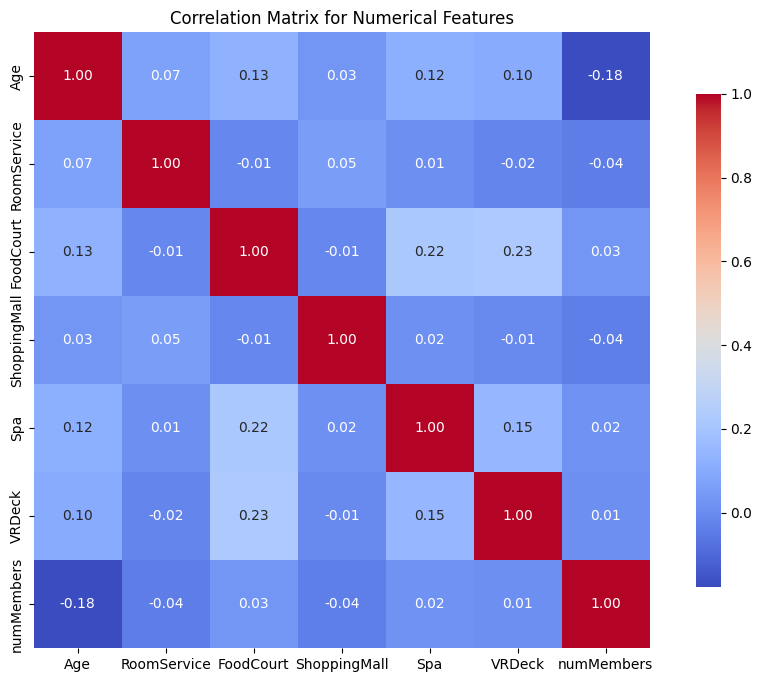

In [44]:
# Plot the correlation matrix for numerical columns
plt.figure(figsize=(12, 8))
sns.heatmap(train_x[num_columns].corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix for Numerical Features')
plt.show()

There is no correlation between any of the numerical features, so we can't remove any of them.

### Normalization
Let's normalize the numerical variables with a min-max normalizer in order to reduce the computation time during the training part.

In [46]:
# Normalize the numerical variables with a min-max normalizer
scaler = MinMaxScaler()
scaler.fit(train_x[num_columns])

train_x[num_columns] = scaler.transform(train_x[num_columns])
test_x[num_columns] = scaler.transform(test_x[num_columns])

In [47]:
# Print distribution of numerical features after normalization
for col in num_columns:
    print(f"\n\nDistribution for {col}:")
    print(train_x[col].describe())



Distribution for Age:
count    8693.000000
mean        0.364911
std         0.181507
min         0.000000
25%         0.253165
50%         0.341772
75%         0.468354
max         1.000000
Name: Age, dtype: float64


Distribution for RoomService:
count    8693.000000
mean        0.015559
std         0.046069
min         0.000000
25%         0.000000
50%         0.000000
75%         0.004258
max         1.000000
Name: RoomService, dtype: float64


Distribution for FoodCourt:
count    8693.000000
mean        0.015238
std         0.053499
min         0.000000
25%         0.000000
50%         0.000000
75%         0.003119
max         1.000000
Name: FoodCourt, dtype: float64


Distribution for ShoppingMall:
count    8693.000000
mean        0.007310
std         0.025443
min         0.000000
25%         0.000000
50%         0.000000
75%         0.001362
max         1.000000
Name: ShoppingMall, dtype: float64


Distribution for Spa:
count    8693.000000
mean        0.013777
std         0.05

### Principal Component Analysis (PCA)
After normalize the numerical features, let's analyze the whole set of features with PCA in order to reduce the dimensionality of the problem without losing too much information.

In [48]:
# Initialize PCA asking to reduce dimensionality while preserving 98% of variance
pca = PCA(n_components=0.98, random_state=0)

train_x_pca = pca.fit_transform(train_x[num_columns])

# Obtain the explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("\nExplained variance ratio for each principal component:")
print(explained_variance)
print(f"\n% of variance kept: {np.sum(explained_variance) * 100:.2f}%")

# Transform the test set
test_x_pca = pca.transform(test_x[num_columns])


Explained variance ratio for each principal component:
[0.57183787 0.32104558 0.03662144 0.02252234 0.02152877 0.01969752]

% of variance kept: 99.33%


We configure PCA to retain at least 98% of the total variance that the features contain. The obtained results are telling us that only one variable was removed, because to remove the next one will drop the variance by a ~2%. 

At the end is not a problem to only have the dimensionality of the problem reduced by one, because at the end we don't have a huge amount of features on this problem, so the dataset is not too complex.

Finally we joint the resulting features for apply PCA with the categorical features. 

In [49]:
# Select categorical features from train_x, val_x, and test_x
train_cat = train_x[cat_columns].values
test_cat = test_x[cat_columns].values

# Combine PCA features and categorical features
X_train_final = np.hstack([train_x_pca, train_cat])
X_test_final = np.hstack([test_x_pca, test_cat])

print("Final train feature shape:", X_train_final.shape)
print("Final test feature shape:", X_test_final.shape)

Final train feature shape: (8693, 12)
Final test feature shape: (4277, 12)


## 3) Train the resulting dataset

### 5-fold Cross-Validation